<a href="https://colab.research.google.com/github/maciejskorski/min-entropy_MC/blob/main/CryptoMarkovChains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install support for pygraphviz, see https://gist.github.com/korakot/a80c04a1945b06e2f4a053f92fecfbf9
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


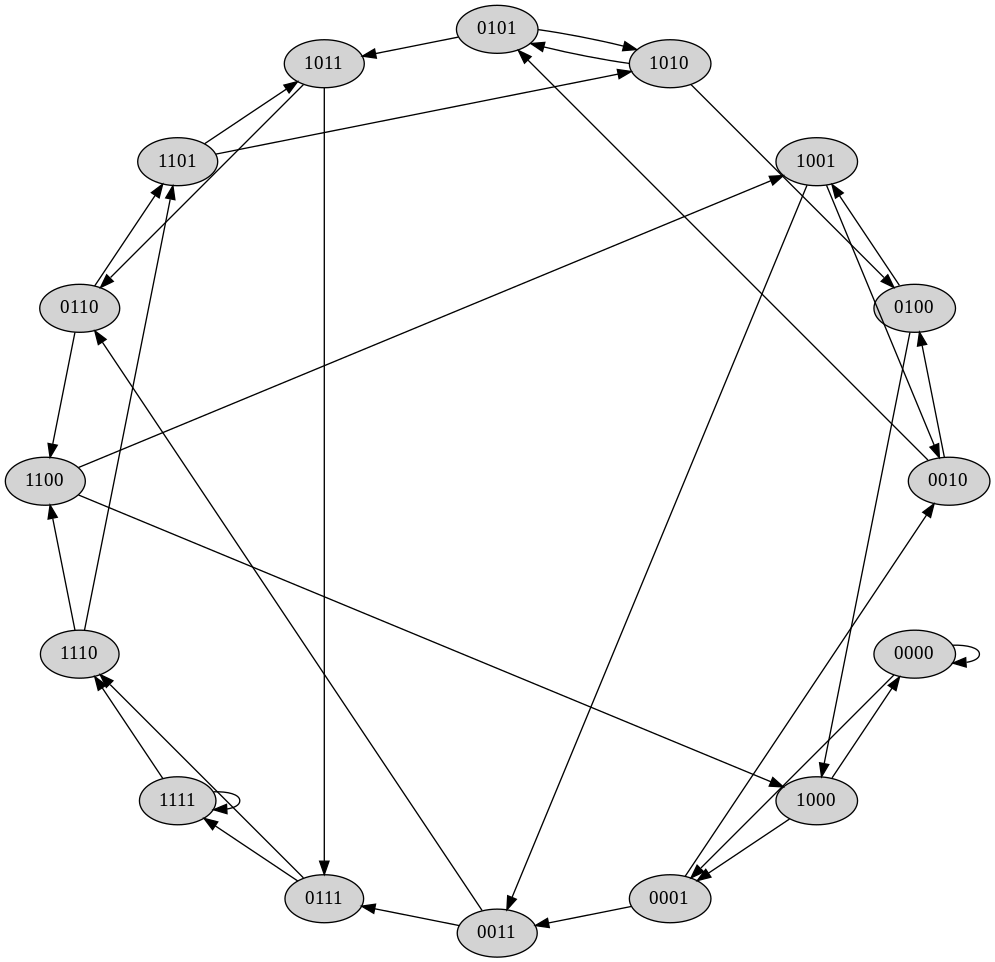

In [ ]:
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Image

import itertools 

g = nx.DiGraph()

def debruijn_graph(k,n):

  for t in itertools.product(range(k),repeat=n):
    t = ''.join(map(str,t))
    for c in range(k):
      t_next = t[1:] + str(c)
      g.add_edge(t,t_next)
  
  return g

g = debruijn_graph(2,4)
for n in g.nodes:
  g.nodes[n]['style'] = 'filled'
  g.nodes[n]['fillcolor']='lightgray'


A = nx.drawing.nx_agraph.to_agraph(g) 
A.layout('circo')                                                                 
A.draw('debruijn.png')
Image('debruijn.png')

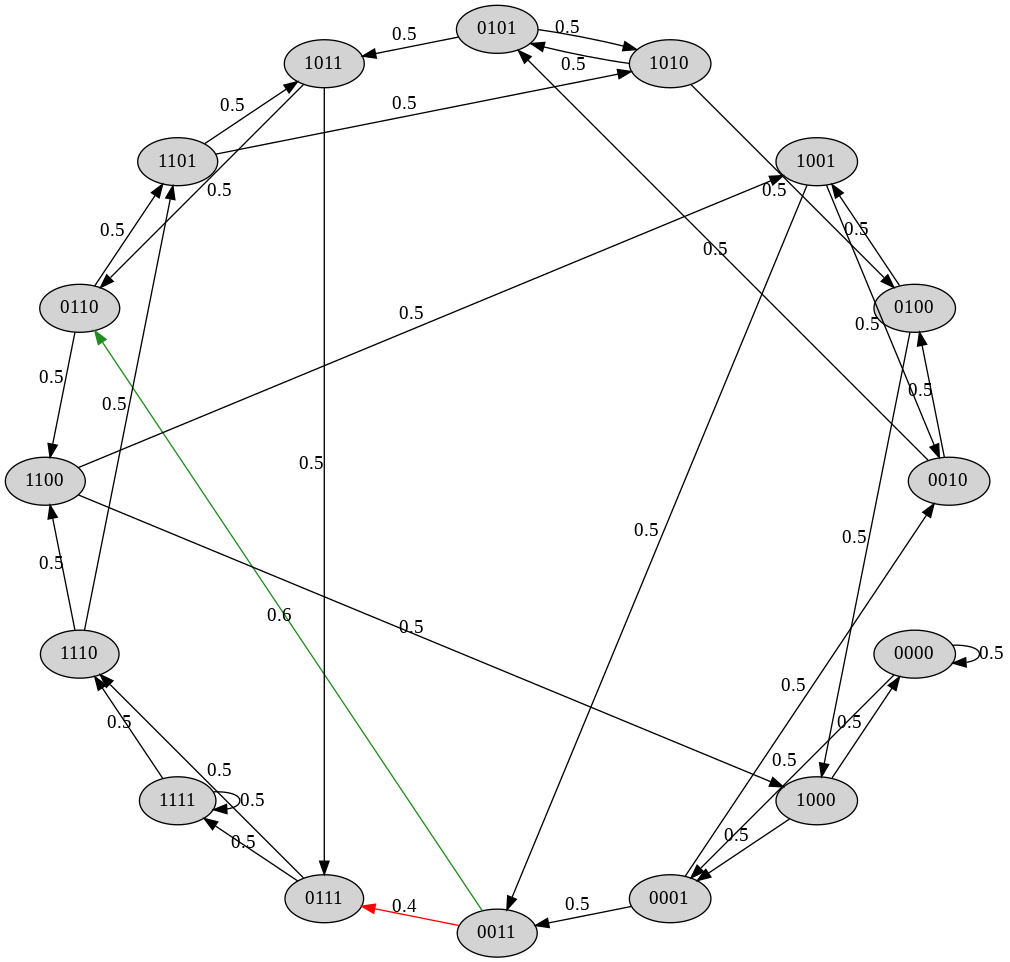

In [ ]:
weights = {e:0.5 for e in g.edges}
weights[('0011','0110')] =  0.6
weights[('0011','0111')] =  0.4

colors = {('0011','0110'):'forestgreen',('0011','0111'):'red'}

nx.set_edge_attributes(g,weights,name='weight')
nx.set_edge_attributes(g,weights,name='label')
nx.set_edge_attributes(g,colors,name='color')

A = nx.drawing.nx_agraph.to_agraph(g) 
A.layout('circo')                                                                 
A.draw('debruijn_weighted1.png')
Image('debruijn_weighted1.png')

In [ ]:
## MMC: 0011>0110>1100>1001>0011

(3-np.log2(0.6))/4

0.9342413985415515

In [ ]:
import numpy as np

def MMC(g):
  '''
    the minimum mean cycle for a given graph
    g is a networknx graph with edge weights
  '''

  ## init
  nodes = list(g.nodes)
  edges = g.edges
  deltas = [ {n:np.inf for n in nodes} for k in range(len(nodes)+1) ]
  deltas[0][nodes[0]] = 0

  ## compute shortest paths
  rev_g = nx.reverse(g)
  ks = np.arange(len(nodes)+1)
  for k in ks[1:]:
    deltas[k]={w:min(deltas[k-1][v]+edges[(v,w)]['weight'] for v in rev_g[w]) for w in nodes}

  ## optimize
  deltas = np.array([[deltas[k][n] for n in nodes] for k in ks])
  mus = (deltas[-1]-deltas[ks[:-1]])/(ks[-1]-ks[:-1]).reshape(-1,1)
  return mus.max(1).min(0)

def MinEntropy(g):
  '''
    an approximation of the min-entropy rate of a random walk g
    g is a networknx graph with edge weights (transitions)
  '''
  ## compute negative log-odds graph
  g_log = nx.DiGraph(g)
  p = nx.get_edge_attributes(g,'weight')
  neg_logp = {k:-np.log2(v) for k,v in p.items()}
  nx.set_edge_attributes(g_log,neg_logp,name='weight')
  ## return its MMC as the entropy estimate
  return MMC(g_log)


MinEntropy(g)

0.9544885752346173

In [ ]:
!pip install rdtsc

  Created wheel for rdtsc: filename=rdtsc-0.2.1-cp36-none-any.whl size=3536 sha256=f7981541c1ff004fe2641b5f907b76e694ec1a8aadaaca451a60d8bc0a72a712
  Stored in directory: /root/.cache/pip/wheels/49/6d/15/58dad446e3e456c82a54d5ac6a83cdd1a7b43116b8b823cac4
Successfully built rdtsc


In [ ]:
## estimate markov chains

from collections import deque,Counter

def slide_window(itr,n=2):
  itr = iter(itr)
  q = deque(maxlen=n)
  q.extend( itertools.islice(itr,n) )
  yield tuple(q)
  for i in itr:
    q.append(i)
    yield tuple(q)

def markov_matrix(itr,order):
  itr = slide_window(itr,n=order+1)
  itr = map(lambda s:''.join(s),itr)
  itr = map(lambda t: (t[:-1],t[1:]), itr)
  cnt_cooccurr = Counter(itr)
  cnt_occurr = Counter()
  for k,v in cnt_cooccurr.items():
    cnt_occurr.update({k[0]:v})
  return {k:v/cnt_occurr.get(k[0]) for k,v in cnt_cooccurr.items()}

In [ ]:
## get data

import rdtsc

significant_bits = [1]
chain_orders = [2,4,6,8,10,12]

outs = []

for b in significant_bits:

  ## prepare data
  data = range(1000000)
  data = map(rdtsc.get_cycles,data)
  data = map(lambda x:x%2**b,data)
  data = map(lambda x: format(x,'0%sb'%b),data)
  data = itertools.chain(*data)
  data = list(data)

  ## estimate models
  for order in chain_orders:
    weights = markov_matrix(data,order)

    ## compute entropy

    g = nx.DiGraph(weights.keys())
    nx.set_edge_attributes(g,weights,name='weight')
    out = MinEntropy(g)
    print(b,order,out)
    outs.append(out)

1 2 0.9983925787401182
1 4 0.9947378808734649
1 6 0.9906016028738627
1 8 0.9706486678324779
1 10 0.9543228494796787
1 12 0.9008849529460474


In [ ]:
import pandas as pd
df = pd.DataFrame(outs)
df.index = chain_orders
df

,0
2,0.998393
4,0.994738
6,0.990602
8,0.970649
10,0.954323
12,0.900885


In [ ]:
0.93*8

7.44

In [ ]:
q.pop()

1

In [ ]:
data = iter(range(100))

w1 = itertools.islice(data,10)
w2 = itertools.islice(data,10)
w3 = itertools.islice(data,10)
for t in itertools.chain([w1],[w2]):
  print(tuple(t))

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
(10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
